## Natural Language Processing (NLP)

### Import Data
First of all we need some data to work with. For this propose we can use the [public SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) on machine learning repository of UCI.

After downloding and unzipping the data, there would be two files:
- readme file including the information about the data Set
- SMSSpamCollection file which contains the data

In summary, the data contains more than 5000 messages that have been collected for SMS Spam research (4,827 SMS legitimate messages (86.6%) and a total of 747 (13.4%) spam messages).

The files contain one message per line. Each line is composed by two columns: one with label (ham or spam) and other with the raw text. 

In [1]:
# Import messages from file
messages = [line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

# Show the first 10 messages
for num, message in enumerate(messages[:10]):
    print(num, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, آ£1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea آ£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 1

As you can see in the print above, this is a TSV (_Tab Separated Values_) file and secondly messages have labels _ham_ and _spam_, which corresponds to _normal_ and _spam_ messages, respectively.

In the continue the main goal of this article is to setup a machine learning model to identify _ham_ and _spam_ messages itself. It would be a supervised method and we will use some part of the messages for the training process. 

But before that, we will do some analysis on the messages. For convenience 

In [2]:
# import pandas library
import pandas as pd 

df_messages = pd.read_csv('smsspamcollection/SMSSpamCollection',
                        sep='\t', names=['label','message'])

In [3]:
# Check the dataframe
df_messages

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


As you can see, there are 5572 messages in our dataframe. First of all we extract some general information from the data:

In [4]:
# Some general info of the messages dataframe
df_messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Based on the description, there are 2 unique labels, ham and spam. Ham is the more frequent label which repeated 4825 times. Almost, all of the messages were different and the top repeated message were _"Sorry, I'll call later"_, which repeated 30 times. 

We can extract info of each label separately to have more detailed informaiton:     

In [5]:
df_messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

So here we can find out more details on each of the labels. In the next step we'll extract some features of the messages, like length etc, and add them to the dataframe.

In [6]:
# Extract and add length of each message to the dataframe
df_messages['length'] = df_messages['message'].apply(len)

# Check the dataframe
df_messages

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


### Visualization

It would be nice of we add some visualization.

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns 

<AxesSubplot:xlabel='length', ylabel='Count'>

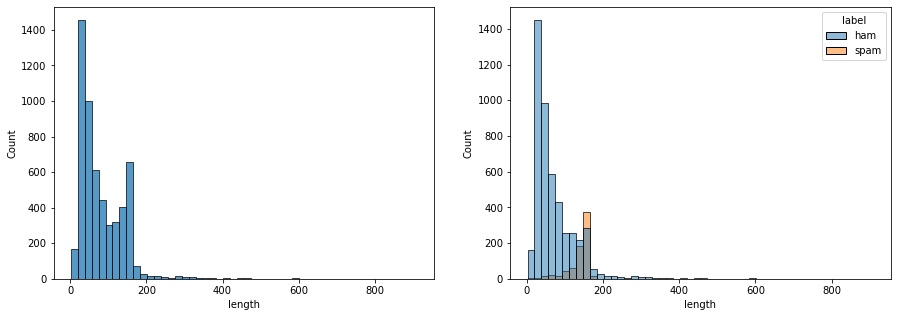

In [8]:
# plot histogram of the length of messages
# + also for labels separately

fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(df_messages, x='length', bins = 50, ax=axes[0])
sns.histplot(df_messages, x='length', hue='label', bins = 50, ax=axes[1])

### Text Pre-Processing

Here the messages are in the string format. The issue is that we need a solution to convert these data to some numerical features as it is required for classifications models. There are several methods to convert the corpus to the numerical features vectors, the simples one is "Bag of words". In this model every word consider as a single quantity and the whole corpus considered as a bag of single words.

The bag-of-words model is commonly used in methods of document classification where the (frequency of) occurrence of each word is used as a feature for training a classifier.

So the porpuse of this section is to convert raw messages (sequence of characters) into vectors (sequences of numbers).

In the continue, first, we would split messages into list of individual words. We like to remove punctuations and also common words ([stop words](https://en.wikipedia.org/wiki/Stop_word) in computing), such as 'the', 'a', etc. For this porpuse, we would benefited by the built-in functions in NLTK and string libraries. 

Before seting up a funciton, it would be useful to check the process on a temporary test text and see what would happen. 

In [9]:
# import string library to analyze the text
import string

# test text
test = 'This is just a text, including some common words, like: the, a, ... and bunch of punctuations! OK?'

# remove punctuations, join the letters and then check it
test_nopunc = [char for char in test if char not in string.punctuation]
test_nopunc = ''.join(test_nopunc)
test_nopunc

'This is just a text including some common words like the a  and bunch of punctuations OK'

In [16]:
# Import library to remove stop words
from nltk.corpus import stopwords

# Show some stop words
', '.join(stopwords.words('english')[0:20])

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his"

Now we would apply removing stop words on splitted test_nopunc. We use .lower() method to make sure that there aren't any capital letters in our list. 

In [21]:
# Remove stop words and show the result
test_nopunc_cleaned = [word for word in test_nopunc.split() if word.lower() not in stopwords.words('english')]
test_nopunc_cleaned

['text', 'including', 'common', 'words', 'like', 'bunch', 'punctuations', 'OK']

So now we know that everything wokrs fine, we can put all of them together in a function to apply on our textdata and clean them. 

In [22]:
def clean_text(text):
    '''
    Function to clean the text:
    - remove punctuations
    - remove stop words
    
    Args:
        text         (str): A text which is supposed to be pre-processed
        
    Returns:
        text_cleaned (lst): list of strings (single words)
    '''
    
    # remove punctuations
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # remove stopwords
    text_cleaned = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return text_cleaned

review of the original dataframe:

In [23]:
# review of the messages dataframe
df_messages

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In the continue we wil __tokenize__ the messages, and convert the text strings into a list of __tokens__ (the important word that we need). To save time lets check the first 10 messages.

In [25]:
df_messages['message'][0:10].apply(clean_text)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
5    [FreeMsg, Hey, darling, 3, weeks, word, back, ...
6    [Even, brother, like, speak, treat, like, aids...
7    [per, request, Melle, Melle, Oru, Minnaminungi...
8    [WINNER, valued, network, customer, selected, ...
9    [mobile, 11, months, U, R, entitled, Update, l...
Name: message, dtype: object

### Vectorizaiton

In this section we will convert messages, which I have them now as list of tokens (also known as [lemmas](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) into vectors that be suitable for machine learning models. 

For this purpose, we'll do it in the following steps:

1. __Term frequency:__ count the number of time a word occurs in a message
2. __Inverse document frequency:__ Weigh the counts (high frequent tokens get lower weights)
3. __L2 norm:__ Normalize the vectors to unit length

Built in __CountVectorizer__ in SciKit Learn do the first step (term frequency). This model will convert a collection of text documents to a matrix of token counts. 
The output would be a [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) as there are lots of words in all messages.

In [27]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# make bag of words (bow) applying CountVectorizer
# specify the analyzer to be our own previously defined function
bow = CountVectorizer(analyzer=clean_text).fit(df_messages['message'])

# print total number of words
print(len(bow.vocabulary_))

11425


So there are 11425 unique words after removing punctuations and stop words! 

Lets check one of the messages.

In [57]:
# Select and check a sample message
message_sample = df_messages['message'][6]
message_sample

'Even my brother is not like to speak with me. They treat me like aids patent.'

In [56]:
# Make bag of words of the sample message and print counts
bow_sample = bow.transform([message_sample])
print(bow_sample)
print(bow_sample.shape)

  (0, 1802)	1
  (0, 4590)	1
  (0, 5193)	1
  (0, 7800)	2
  (0, 8761)	1
  (0, 9971)	1
  (0, 10629)	1
(1, 11425)


There are seven unique words in the sixth message, only one of them appears twice. Let's see what was that word:

In [58]:
# Name of the repeated word (row 7800)
bow.get_feature_names()[7800]

'like'

Great! And we can do the same with the entire of SMS corpus using _.transform_ method.

In [60]:
# apply transformation on the whole message dataframe
message_bow = bow.transform(df_messages['message'])

# print some properties
print('Shape of Sparse Matrix: {}'.format(message_bow.shape))
print('Number of non-zero occurences: {}'.format(message_bow.nnz))
print('Sparsity: {:.2f}%'.format(100*message_bow.nnz/(message_bow.shape[0]*message_bow.shape[1])))

Shape of Sparse Matrix: (5572, 11425)
Number of non-zero occurences: 50548
Sparsity: 0.08%


#### Visualization of message bag of words (bow)

It would be useful to visualize what we have in our sparse matrix (our bow).

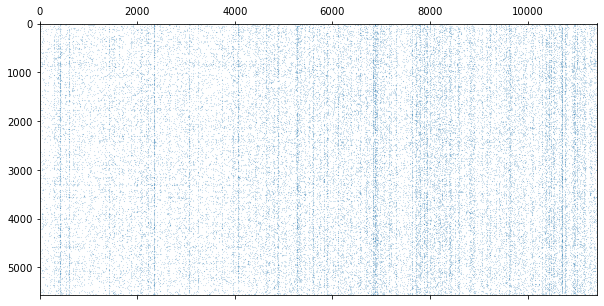

In [156]:
# Visualize the message_bow (it is kind of sparse matrix)
fig, ax = plt.subplots(figsize=(12,5))
plt.spy(message_bow, markersize=0.05)

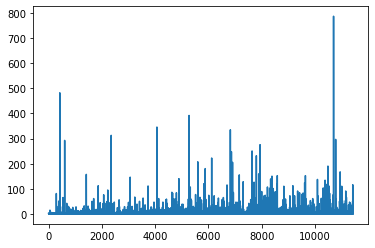

In [97]:
# import numpy to convert matrix to array
import numpy as np
bow_sum = np.squeeze(np.array(message_bow.sum(axis=0)))

# plot occurence of repeatition of each word in total messages
plt.plot(np.arange(0,len(bow_sum)), bow_sum)

It is good to know for examaple which words repeated more than 100 times in total messages.

In [154]:
# Extract indices of high repeated words
bow_high, = np.where(bow_sum > 100)
# Extract the name of words and check the output
words_hf = [bow.get_feature_names()[item] for item in bow_high] # high frequent words (words_hf)
', '.join(words_hf)

'2, 4, Call, FREE, Ill, Im, Ok, Sorry, U, back, call, cant, come, da, day, dont, free, get, go, going, good, got, home, im, know, later, like, lor, love, ltgt, mobile, much, n, need, night, ok, one, phone, r, see, send, still, take, tell, text, think, time, today, u, ur, want, week, ü'

It doesn't seem that there is any important word among these list. 